# Setup


In [24]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

from config import (
    RANDOM_STATE,
    CSV_FILEPATH_MODEL_READY_DATA,
    EMBEDEDINGS_FILEPATH_Mini_LML6_v2,
    EMBEDEDINGS_FILEPATH_mpnet_base_v2,
    EMBEDEDINGS_FILEPATH_open_ai_api,
    EMBEDEDINGS_FILEPATH_tf_idf_bigrams,
    EMBEDEDINGS_FILEPATH_tf_idf_monograms,
    load_embeddings_and_data,
)

TARGET_COL = "points"
TEST_SIZE = 0.2
IS_FIRST_COLUMN_INDEX = False


# Embeddings catalog


In [25]:
EMBEDDING_SOURCES = {
    "MiniLM-L6-v2": EMBEDEDINGS_FILEPATH_Mini_LML6_v2,
    "mpnet-base-v2": EMBEDEDINGS_FILEPATH_mpnet_base_v2,
    "OpenAI-API": EMBEDEDINGS_FILEPATH_open_ai_api,
    "TF-IDF bigrams": EMBEDEDINGS_FILEPATH_tf_idf_bigrams,
    "TF-IDF monograms": EMBEDEDINGS_FILEPATH_tf_idf_monograms,
}

embedding_order_all = list(EMBEDDING_SOURCES.keys())


# Data loading helper


In [26]:
def load_embedding_dataset(embedding_path, csv_path=CSV_FILEPATH_MODEL_READY_DATA):
    # CSV_FILEPATH_MODEL_READY_DATA has no explicit index column
    return load_embeddings_and_data(
        embeddings_filepath=embedding_path,
        csv_filepath=csv_path,
        isFirstColumnIndex=IS_FIRST_COLUMN_INDEX,
        check_length=True,
    )


# Feature preparation (preserve vintage nulls)


In [27]:
def prepare_features(df, target_col=TARGET_COL, vintage_col="vintage"):
    df = df.copy()

    # Preserve information about missing vintage values
    if vintage_col in df.columns:
        df["vintage_missing"] = df[vintage_col].isna().astype(int)

    y = df[target_col]
    X = df.drop(columns=[target_col])

    # Keep numeric features only (all model-ready features are numeric)
    X = X.select_dtypes(include="number")

    # Embedding columns are integers (0..N-1) after concatenation
    base_cols = [c for c in X.columns if not isinstance(c, int)]
    emb_cols = [c for c in X.columns if isinstance(c, int)]

    # sklearn requires uniform (string) feature names
    X.columns = X.columns.astype(str)
    base_cols = [str(c) for c in base_cols]
    emb_cols = [str(c) for c in emb_cols]

    return X, y, base_cols, emb_cols


# Preprocessing pipelines


In [28]:
def build_preprocessor_all_features():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])


def build_preprocessor_with_polynomial(base_cols, emb_cols, degree=2):
    # Apply polynomial only to base features to keep feature count manageable
    transformers = []

    if base_cols:
        base_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scaler", StandardScaler()),
        ])
        transformers.append(("base", base_pipeline, base_cols))

    if emb_cols:
        emb_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
        transformers.append(("emb", emb_pipeline, emb_cols))

    return ColumnTransformer(transformers, remainder="drop")


# Regression models catalog


In [29]:
def get_regression_builders():
    return {
        "Linear": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", LinearRegression()),
        ]),
        "Ridge": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", Ridge(alpha=1.0)),
        ]),
        "Lasso": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE)),
        ]),
        "ElasticNet": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=RANDOM_STATE)),
        ]),
        "PolynomialRidge(deg2)": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_with_polynomial(base_cols, emb_cols, degree=2)),
            ("model", Ridge(alpha=1.0)),
        ]),
    }

regression_builders = get_regression_builders()
regression_order_all = list(regression_builders.keys())


## Experiment selection


In [30]:
# Choose a subset (None = all)
ACTIVE_EMBEDDINGS = [ #  None 
    "MiniLM-L6-v2",
    "mpnet-base-v2",
    # "OpenAI-API",
    # "TF-IDF bigrams",
    # "TF-IDF monograms",
]
ACTIVE_REGRESSIONS = ["Linear", "Ridge", "Lasso"] # None
SHOW_PROGRESS = True


def select_dict_subset(source_dict, active_keys):
    if active_keys is None:
        return source_dict
    missing = [k for k in active_keys if k not in source_dict]
    if missing:
        raise ValueError(f"Missing keys: {missing}")
    return {k: source_dict[k] for k in active_keys}


EMBEDDING_SOURCES_ACTIVE = select_dict_subset(EMBEDDING_SOURCES, ACTIVE_EMBEDDINGS)
regression_builders_active = select_dict_subset(regression_builders, ACTIVE_REGRESSIONS)

embedding_order = list(EMBEDDING_SOURCES_ACTIVE.keys())
regression_order = list(regression_builders_active.keys())


To add new embeddings, extend `EMBEDDING_SOURCES`.
To add new regressions, extend `get_regression_builders()` with a new entry.


# Metrics and evaluation helpers


In [31]:
METRICS = ["R2", "MAE", "MSE", "RMSE", "MAPE", "FitTimeSec"]


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def evaluate_models_for_embedding(df, embedding_name, builders, show_progress=True, progress=None):
    X, y, base_cols, emb_cols = prepare_features(df)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    results = []
    predictions = {}

    for reg_name, build_model in builders.items():
        if progress is not None:
            progress["done"] += 1
            if show_progress:
                print(f"[{progress['done']}/{progress['total']}] {embedding_name} | {reg_name}")
        elif show_progress:
            print(f"{embedding_name} | {reg_name}")

        model = build_model(base_cols, emb_cols)
        start = time.perf_counter()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fit_time = time.perf_counter() - start

        metrics = compute_metrics(y_test, y_pred)
        results.append({
            "embedding": embedding_name,
            "regression": reg_name,
            **metrics,
            "FitTimeSec": fit_time,
        })
        predictions[(embedding_name, reg_name)] = (y_test, y_pred)

    return results, predictions


def run_all_experiments(embedding_sources, builders, show_progress=True):
    all_results = []
    all_predictions = {}

    progress = {
        "done": 0,
        "total": len(embedding_sources) * len(builders),
    }
    if show_progress:
        print(f"Total combinations: {progress['total']}")

    for embedding_name, embedding_path in embedding_sources.items():
        if show_progress:
            print(f"Loading: {embedding_name}")
        df = load_embedding_dataset(embedding_path)
        results, preds = evaluate_models_for_embedding(
            df, embedding_name, builders, show_progress=show_progress, progress=progress
        )
        all_results.extend(results)
        all_predictions.update(preds)

    return pd.DataFrame(all_results), all_predictions


# Run the full experiment suite


In [32]:
results_df, predictions_cache = run_all_experiments(
    EMBEDDING_SOURCES_ACTIVE,
    regression_builders_active,
    show_progress=SHOW_PROGRESS,
)

results_df


Total combinations: 6
Loading: MiniLM-L6-v2
[1/6] MiniLM-L6-v2 | Linear
[2/6] MiniLM-L6-v2 | Ridge
[3/6] MiniLM-L6-v2 | Lasso
Loading: mpnet-base-v2
[4/6] mpnet-base-v2 | Linear
[5/6] mpnet-base-v2 | Ridge
[6/6] mpnet-base-v2 | Lasso


,embedding,regression,R2,MAE,MSE,RMSE,MAPE,FitTimeSec
0,MiniLM-L6-v2,Linear,0.683346,1.355409,2.968753,1.723007,0.015332,8.694217
1,MiniLM-L6-v2,Ridge,0.683347,1.355408,2.968746,1.723005,0.015332,5.337310
2,MiniLM-L6-v2,Lasso,0.682899,1.356738,2.972946,1.724223,0.015347,27.905460
3,mpnet-base-v2,Linear,0.719649,1.275971,2.628402,1.621235,0.014431,15.086920
4,mpnet-base-v2,Ridge,0.719658,1.276005,2.628310,1.621206,0.014431,10.396269
5,mpnet-base-v2,Lasso,0.717426,1.281445,2.649244,1.627650,0.014493,394.369390


## Timing summary


In [ ]:
# Longest combinations (fit + predict)
results_df.sort_values("FitTimeSec", ascending=False).head(10)

,embedding,regression,R2,MAE,MSE,RMSE,MAPE,FitTimeSec
5,mpnet-base-v2,Lasso,0.717426,1.281445,2.649244,1.627650,0.014493,394.369390
2,MiniLM-L6-v2,Lasso,0.682899,1.356738,2.972946,1.724223,0.015347,27.905460
3,mpnet-base-v2,Linear,0.719649,1.275971,2.628402,1.621235,0.014431,15.086920
4,mpnet-base-v2,Ridge,0.719658,1.276005,2.628310,1.621206,0.014431,10.396269
0,MiniLM-L6-v2,Linear,0.683346,1.355409,2.968753,1.723007,0.015332,8.694217
1,MiniLM-L6-v2,Ridge,0.683347,1.355408,2.968746,1.723005,0.015332,5.337310


# Metric tables (regressions x embeddings)


In [39]:
results_df["embedding"] = pd.Categorical(
    results_df["embedding"], categories=embedding_order, ordered=True
)
results_df["regression"] = pd.Categorical(
    results_df["regression"], categories=regression_order, ordered=True
)

metric_tables = {}
for metric in METRICS:
    table = (
        results_df
        .pivot(index="regression", columns="embedding", values=metric)
        .reindex(index=regression_order, columns=embedding_order)
    )
    metric_tables[metric] = table

# Metric tables (one table per metric)


In [35]:
for metric in METRICS:
    print(metric)
    display(metric_tables[metric])


R2


embedding,MiniLM-L6-v2,mpnet-base-v2
regression,,
Linear,0.683346,0.719649
Ridge,0.683347,0.719658
Lasso,0.682899,0.717426


MAE


embedding,MiniLM-L6-v2,mpnet-base-v2
regression,,
Linear,1.355409,1.275971
Ridge,1.355408,1.276005
Lasso,1.356738,1.281445


MSE


embedding,MiniLM-L6-v2,mpnet-base-v2
regression,,
Linear,2.968753,2.628402
Ridge,2.968746,2.628310
Lasso,2.972946,2.649244


RMSE


embedding,MiniLM-L6-v2,mpnet-base-v2
regression,,
Linear,1.723007,1.621235
Ridge,1.723005,1.621206
Lasso,1.724223,1.627650


MAPE


embedding,MiniLM-L6-v2,mpnet-base-v2
regression,,
Linear,0.015332,0.014431
Ridge,0.015332,0.014431
Lasso,0.015347,0.014493


FitTimeSec


embedding,MiniLM-L6-v2,mpnet-base-v2
regression,,
Linear,8.694217,15.086920
Ridge,5.337310,10.396269
Lasso,27.905460,394.369390


# Boxplot grid (predicted vs actual, like in the reference)


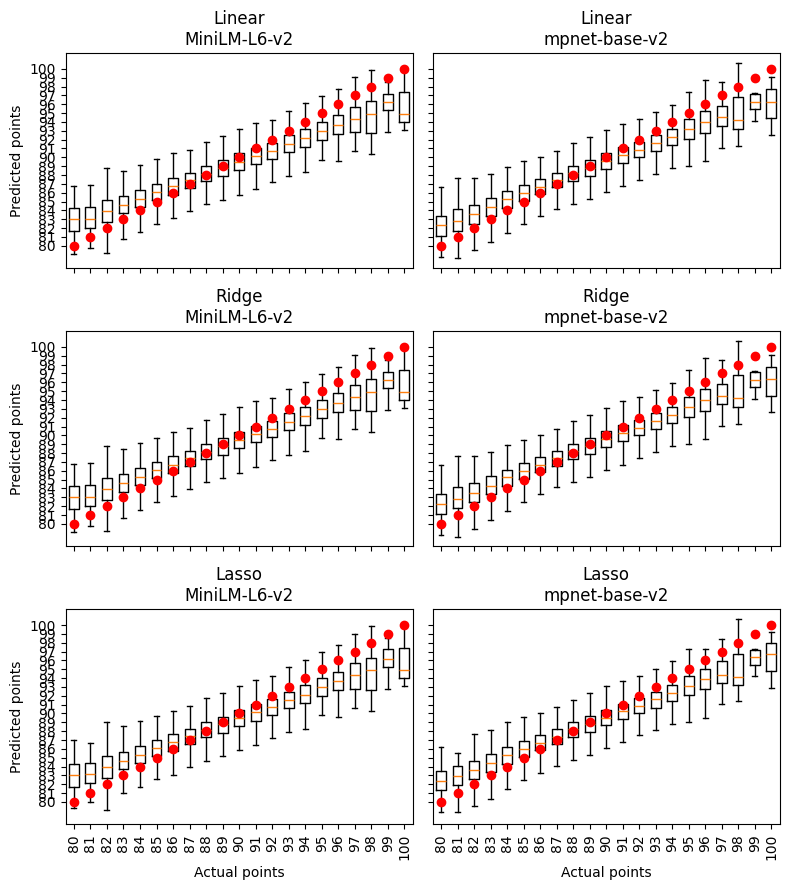

In [36]:
def plot_predicted_vs_actual_boxplot(ax, y_test, y_pred, title=None):
    pred_vs_actual = pd.DataFrame({
        "points": y_test,
        "predicted_points": y_pred,
    })

    forced_points = list(range(80, 101))

    data = [
        pred_vs_actual.loc[pred_vs_actual["points"] == p, "predicted_points"]
        if (pred_vs_actual["points"] == p).any()
        else pd.Series(dtype=float)
        for p in forced_points
    ]

    ax.boxplot(
        data,
        positions=range(1, len(forced_points) + 1),
        widths=0.6,
        showfliers=False,
    )

    x_pos = {p: i + 1 for i, p in enumerate(forced_points)}
    xs = [x_pos[p] for p in forced_points]
    ys = forced_points
    ax.scatter(xs, ys, color="red", zorder=3, label="y = x (80-100)")

    ax.set_xticks(range(1, len(forced_points) + 1))
    ax.set_xticklabels(forced_points, rotation=90)
    ax.set_yticks(forced_points)
    ax.set_xlabel("Actual points")
    ax.set_ylabel("Predicted points")
    if title:
        ax.set_title(title)


def plot_boxplot_grid(predictions, regressions, embeddings):
    n_rows = len(regressions)
    n_cols = len(embeddings)

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True
    )

    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    for i, reg in enumerate(regressions):
        for j, emb in enumerate(embeddings):
            ax = axes[i, j]
            key = (emb, reg)
            if key not in predictions:
                ax.axis("off")
                continue

            y_test, y_pred = predictions[key]
            plot_predicted_vs_actual_boxplot(
                ax,
                y_test,
                y_pred,
                title=f"{reg}\n{emb}",
            )

            if i < n_rows - 1:
                ax.set_xlabel("")
                ax.set_xticklabels([])
            if j > 0:
                ax.set_ylabel("")

    plt.tight_layout()
    plt.show()

plot_boxplot_grid(predictions_cache, regression_order, embedding_order)
